In [1]:
!pip install fasttext # necesario para importar los modulos
!git clone https://github.com/elsonidoq/ml-practico-2022.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.7 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3165353 sha256=1a421edd13bed761eecc02b49e4b04fac8cb9e24db6a76fa289840fbac0a4327
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
Cloning into 'ml-practico-2022'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 202 (delta 108), reused 148 (delta 58), pack-reused 0
Receiving objects: 100% (202/202), 2.99 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
!wget -O title_fasttext.bin https://www.dropbox.com/s/9iltaakdc0pe0ma/title_fasttext.bin?dl=0
!wget -O desc_fasttext.bin https://www.dropbox.com/s/d2zh0u0knqjcvtl/desc_fasttext.bin?dl=0

--2022-10-07 20:02:36--  https://www.dropbox.com/s/9iltaakdc0pe0ma/title_fasttext.bin?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9iltaakdc0pe0ma/title_fasttext.bin [following]
--2022-10-07 20:02:36--  https://www.dropbox.com/s/raw/9iltaakdc0pe0ma/title_fasttext.bin
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc55118dc5b99b9edb74924440e1.dl.dropboxusercontent.com/cd/0/inline/BuaMpS8Jqw8WF5eh9o-BdhqnYIogldLRi73f8yBliwVNYwXlHVSZAqW_4FKcpJO2K6q3-HhgtEM5H5Q03YBeQe-MiKr_EjRmNglOorxbjHEpnEjrF3JpKJIInXlW3xdIb0ylyC5X8cWLYzQVTF8ct8ScCW4SclbGozQ8haRaPOrZRQ/file# [following]
--2022-10-07 20:02:36--  https://uc55118dc5b99b9edb74924440e1.dl.dropboxusercontent.com/cd/0/inline/BuaMpS8Jqw8WF5eh9o-BdhqnYIogldLRi73f8yBliwVNYwXlHVSZAqW_4

In [3]:
import sys
from google.colab import drive

sys.path.append('ml-practico-2022/lib')
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
data_path = '/content/gdrive/MyDrive/taller-model-selection-data'

In [4]:
import pandas as pd
from taller_model_selection.evaluate import load_train_dev_test

(X_train, y_train), (X_dev, y_dev), test = load_train_dev_test(data_path)

{'pct(train)': 0.7837289649483001, 'pct(dev)': 0.11952685477518159, 'pct(test)': 0.09674418027651828}


In [5]:
from taller_model_selection.transformers import FeatureProjection, PretrainedFastTextTransformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


features_pipe = make_union(
    PretrainedFastTextTransformer('title_fasttext.bin', 'title'),
    make_pipeline(
        FeatureProjection(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']),
        SimpleImputer()
    ),
    make_pipeline(
        FeatureProjection(['l3']), 
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse=False, drop='first')
    ), 
    make_pipeline(
        FeatureProjection(['l4']), 
        SimpleImputer(strategy='constant'),
        OneHotEncoder(sparse=False, drop='first')
    ), 
)

lr_pipe = make_pipeline(
    features_pipe,
    LinearRegression()
)


In [6]:
import lightgbm as lgb

lgb_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMRegressor(n_estimators=100)
)

Si estas usando el encoder de la descripccion, el codigo de abajo toma 5 minutos en correr approx

In [7]:
lr_pipe.fit(X_train, y_train)
lgb_pipe.fit(X_train, y_train);

In [8]:
from taller_model_selection.evaluate import Evaluator

ev = Evaluator(X_train, y_train, X_dev, y_dev)

# Hay que asegurarse que el pipeline de arriba tenga el titulo y no la descripccion
ev.eval_pipe('lr', lr_pipe)
ev.eval_pipe('rf', lgb_pipe)

pd.DataFrame(ev.evaluations)

,name,train,dev
0,lr,392472.789838,358645.591731
1,rf,239389.032664,267253.768555


In [16]:
from taller_model_selection.serialize import iter_jl, write_jl
from os import path

def load_submission_data(data_path):
    return list(iter_jl(path.join(data_path, 'X_test.jl')))

X_submit = load_submission_data(data_path)

In [19]:
write_jl(lr_pipe.predict(X_submit), 'lr_pred.jl')

In [22]:
write_jl(lgb_pipe.predict(X_submit), 'lg_pred.jl')

#Ahora podes descargar los submissions!

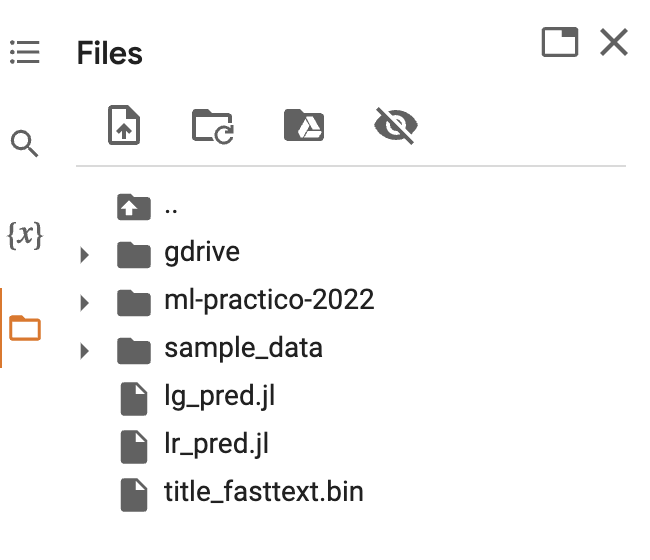

# Subilos al form

https://forms.gle/VtZ9t8nFWkEGFgbE6